## Import libraries

In [105]:
import pandas as pd
import glob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.corpus import stopwords
from IPython.display import set_matplotlib_formats


# Uncomment on first run
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [106]:
# plot themes
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
sns.axes_style("whitegrid")
set_matplotlib_formats('retina')

%matplotlib inline

<ipython-input-106-e6826277f7cd>:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Load data into DataFrame (jobs_all)

In [107]:
# get all jobs data (multiple csvs) into one dataframe

path = 'output'
files = glob.glob(path + "/*.csv")
  
# defining an empty list to store content
jobs_all = pd.DataFrame()
content = []
  
# checking all the csv files in the pth
for filename in files:
    
    # reading content of csv file
    _df = pd.read_csv(filename, index_col=None)
    content.append(_df)
  
# converting content to data frame
jobs_all = pd.concat(content)

# remove all duplicate jobs
jobs_all = jobs_all.drop_duplicates(subset=['job_id'])
jobs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37371 entries, 0 to 2432
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date_time         37371 non-null  object
 1   search_keyword    37371 non-null  object
 2   search_count      37371 non-null  object
 3   job_id            37371 non-null  object
 4   job_title         37322 non-null  object
 5   company           37243 non-null  object
 6   location          37306 non-null  object
 7   remote            37302 non-null  object
 8   update_time       26295 non-null  object
 9   applicants        25892 non-null  object
 10  job_pay           3500 non-null   object
 11  job_time          37202 non-null  object
 12  job_position      29112 non-null  object
 13  company_size      37222 non-null  object
 14  company_industry  35594 non-null  object
 15  job_details       36826 non-null  object
dtypes: object(16)
memory usage: 4.8+ MB


## Initial EDA

### Job Title

In [108]:
# all jobs EDA
jobs_all.job_title.value_counts().head(10)

[REMOTE] Senior Data Engineer – Full-time    1124
Data Scientist – Remote, Full-time            890
Swift Developer – Full-time, Remote           804
Software Engineer                             791
Senior Software Engineer                      650
Data Engineer                                 576
FT Property Researcher (Work From Home)       480
Data Scientist                                369
Senior Data Engineer                          354
Senior Data Engineer – Remote, Full-time      295
Name: job_title, dtype: int64

### Job Position

In [109]:
# Job Postions EDA
# 0 - Internship
# 1 - Entry level
# 2 - Associate
# 3 - Mid-Senior level
# 4 - Director
# 5 - Executive

job_positions = ["Internship", "Entry level", "Associate", "Mid-Senior level", "Director", "Executive"]

jobs_all.job_position.value_counts().head(4)

Mid-Senior level    14996
Associate            8672
Entry level          4525
Director              313
Name: job_position, dtype: int64

## Analysis

### Filtering DataFrame

In [110]:
def filtered_df(jobs_all, job_title, job_position):
    # filter the jobs for title (and position)
    jobs_filtered = jobs_all[jobs_all.job_title.str.contains(job_title, na=False)]
    if job_position != "":
        jobs_filtered = jobs_filtered[jobs_filtered.job_position.str.contains(job_position, na=False)]
    
    # create new column for tokenized words
    jobs_filtered['tokenized_details'] = ""
    for index, row in jobs_filtered.iterrows():
        # lowercase words
        detail = row.job_details.lower()
        # tokenize words
        detail = word_tokenize(detail)
        # handle multi-word tokenization (e.g., Power BI)
        tokenizer = MWETokenizer([('power', 'bi'), ('scala', 'sucks')])
        detail = tokenizer.tokenize(detail)
        # remove duplicates
        detail = list(set(detail))
        # remove stopwords & numbers/punction
        detail = [word for word in detail if word not in stopwords.words('english')] 
        # add to details list
        row.tokenized_details = detail
    
    return jobs_filtered 

### Wordcloud of keywords

In [111]:
def word_cloud(jobs_filtered, keywords):
    # convert df column to list
    analyst_list = jobs_filtered.tokenized_details.tolist()
    # flatten list of lists
    analyst_list = [item for sublist in analyst_list for item in sublist]
    # filter list
    analyst_list = [item for item in analyst_list if item in keywords]
    # convert for wordcloud
    analyst_list = " ".join(words for words in analyst_list)
    # wordcloud the results
    wc_join = WordCloud(background_color="white", collocations=False).generate(analyst_list)
    plt.imshow(wc_join, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

### Bar chart of keywords

In [112]:
def filtered_keywords(jobs_filtered, keywords, title="Keyword Analysis", head=10):
    # get keywords in a column
    count_keywords = pd.DataFrame(jobs_filtered.tokenized_details.sum()).value_counts().rename_axis('keywords').reset_index(name='counts')
    #count_keywords = count_keywords.set_index('keywords')

    # get frequency of occurence of word (as word only appears once per line)
    length = len(jobs_filtered) # number of job postings
    count_keywords['percentage'] = 100 * count_keywords.counts / length

    # plot the results
    count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
    count_keywords = count_keywords.head(head)
    g = sns.barplot(x="keywords", y="percentage", data=count_keywords)
    g.set_xticklabels(g.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')
    plt.xlabel("")
    plt.ylabel("Likelyhood to be in job posting (%)")
    plt.title(title) 
    plt.show(g)
    print(count_keywords)

   

### Analyst Analysis

In [113]:
# went through and picked out the keywords
keywords_analyst = ['excel', 'sql', 'microsoft', 'tableau',  'python', 'word', 
'powerpoint', 'r',  'slack', 'coding', 'looker',
'outlook', 'azure', 'jira', 'twilio', 'server', 'snowflake', 'ai', 'warehousing', 'scrum',
'powerbi', 'shell', 'linux', 'sas', 'sharepoint', 'devops', 'mysql', 'c', 'visio', 
'javascript', 'git', 'mssql', 'vba', 'powerpoints', 'java', 'postgresql', 'spreadsheets',
'pandas', 'gdpr', 'elt', 'scala', 'css', 'spreadsheet', 'alteryx', 'github', 'postgres', 'power_bi', 'spss']

# common terms removed for graphing
# removed = ['power', 'database', 'cloud', 'saas', 'programming', 'etl', 'bi', ]



analyst_entry = filtered_df(jobs_all, "Analyst", "Entry level")

#### Wordcloud

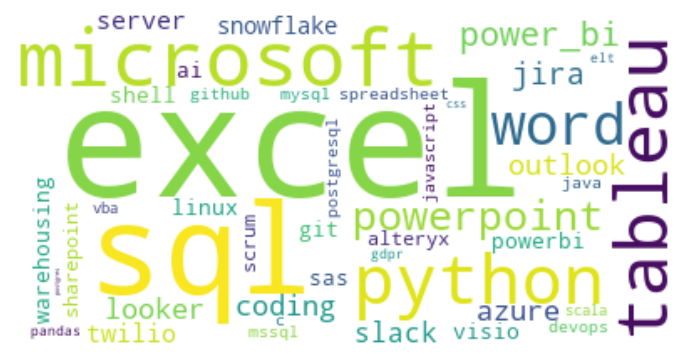

In [114]:
word_cloud(analyst_entry, keywords_analyst)

#### Plots

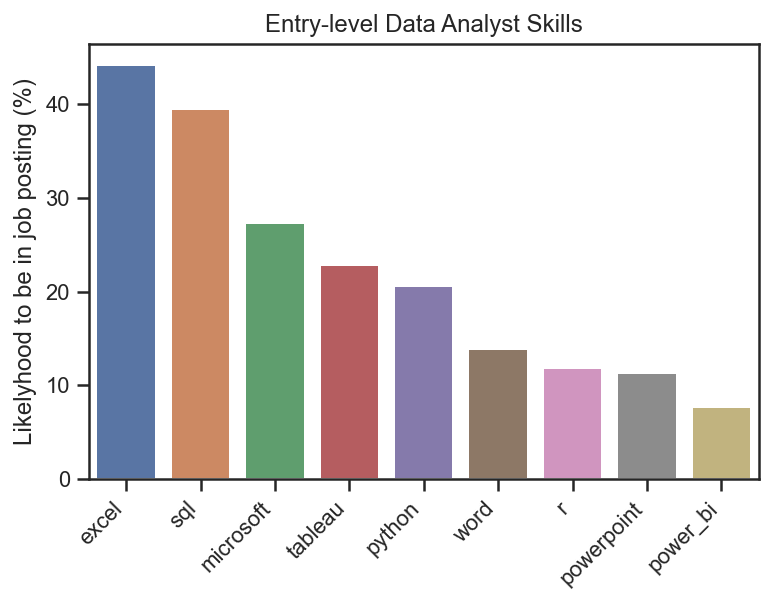

       keywords  counts  percentage
56        excel     309   44.142857
81          sql     276   39.428571
163   microsoft     191   27.285714
232     tableau     160   22.857143
273      python     144   20.571429
437        word      97   13.857143
525           r      83   11.857143
554  powerpoint      79   11.285714
792    power_bi      54    7.714286


In [115]:
filtered_keywords(analyst_entry, keywords_analyst, "Entry-level Data Analyst Skills", 9)

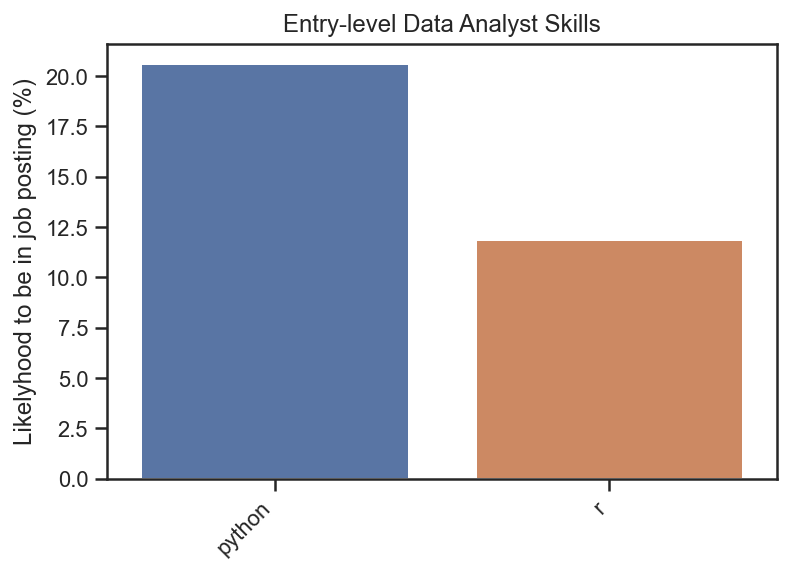

    keywords  counts  percentage
273   python     144   20.571429
525        r      83   11.857143


In [132]:
python_r = ["python", "r"]
filtered_keywords(analyst_entry, python_r, "Entry-level Data Analyst Skills")

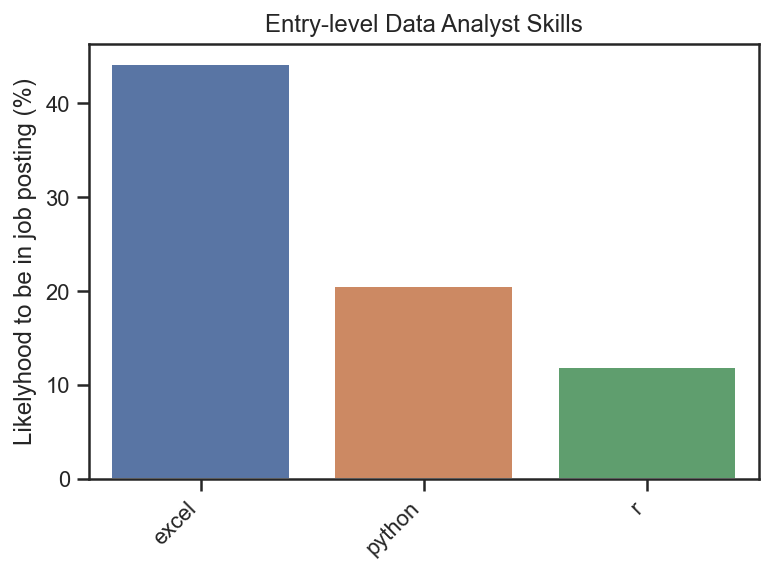

    keywords  counts  percentage
56     excel     309   44.142857
273   python     144   20.571429
525        r      83   11.857143


In [141]:
excel_python_r = ["python", "r", "excel"]
filtered_keywords(analyst_entry, excel_python_r, "Entry-level Data Analyst Skills")

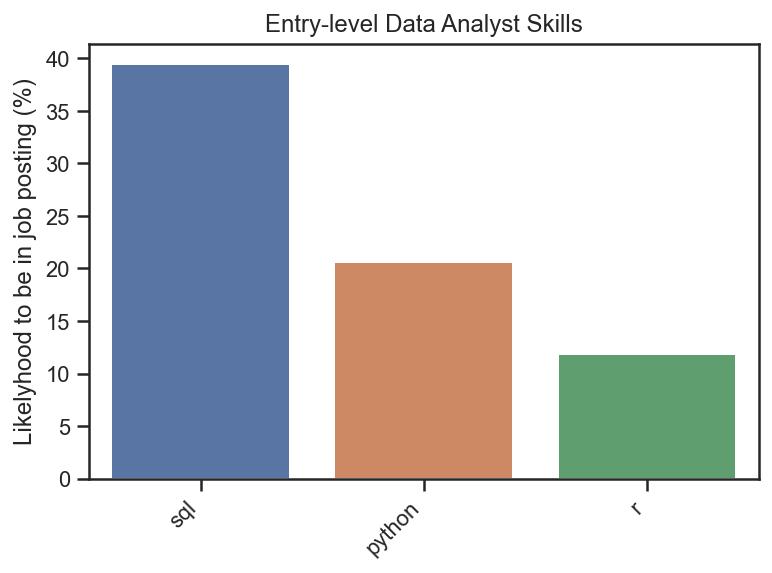

    keywords  counts  percentage
81       sql     276   39.428571
273   python     144   20.571429
525        r      83   11.857143


In [140]:
sql_python_r = ["sql", "r", "python"]
filtered_keywords(analyst_entry, sql_python_r, "Entry-level Data Analyst Skills")

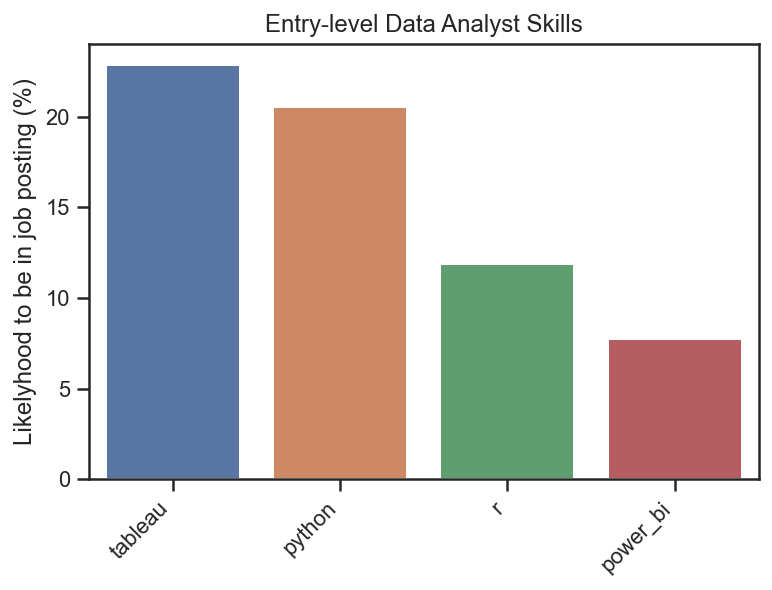

     keywords  counts  percentage
232   tableau     160   22.857143
273    python     144   20.571429
525         r      83   11.857143
792  power_bi      54    7.714286


In [139]:
data_viz = ["tableau", "power_bi", "r", "python"]
filtered_keywords(analyst_entry, data_viz, "Entry-level Data Analyst Skills")

#### Data Analyst Non-Entry level Analysis

In [117]:
non_entry = ["Associate", "Mid-Senior level", "Director", "Executive"]

analyst_nonentry = pd.DataFrame()
for entry in non_entry:
    analyst_nonentry = analyst_nonentry.append(filtered_df(jobs_all, "Analyst", entry))

len(analyst_nonentry)

5890

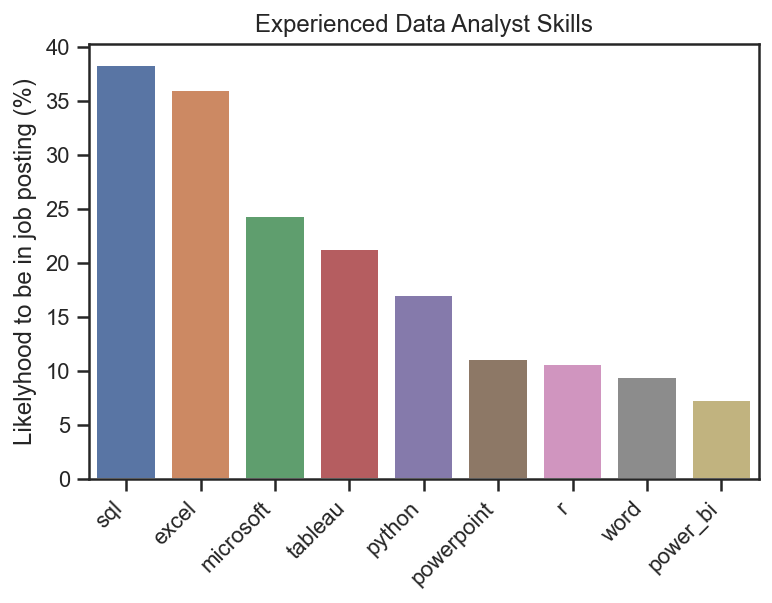

       keywords  counts  percentage
88          sql    2258   38.336163
108       excel    2121   36.010187
208   microsoft    1434   24.346350
259     tableau    1256   21.324278
341      python    1002   17.011885
573  powerpoint     655   11.120543
596           r     629   10.679117
669        word     555    9.422750
849    power_bi     433    7.351443


In [138]:
filtered_keywords(analyst_nonentry, keywords_analyst, "Experienced Data Analyst Skills", 9)

### Data Scientist Analysis

In [120]:
scientist_entry = filtered_df(jobs_all, "Scientist", "Entry level")

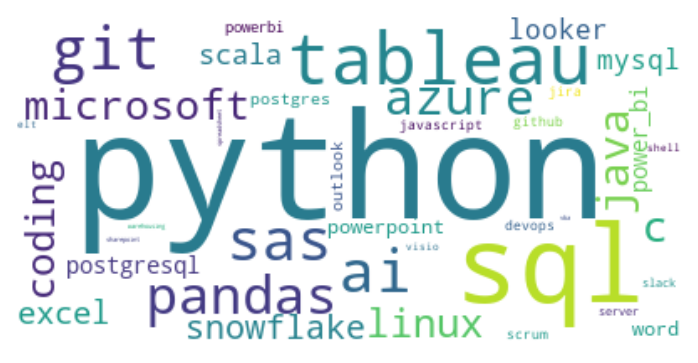

In [121]:
word_cloud(scientist_entry, keywords_analyst)

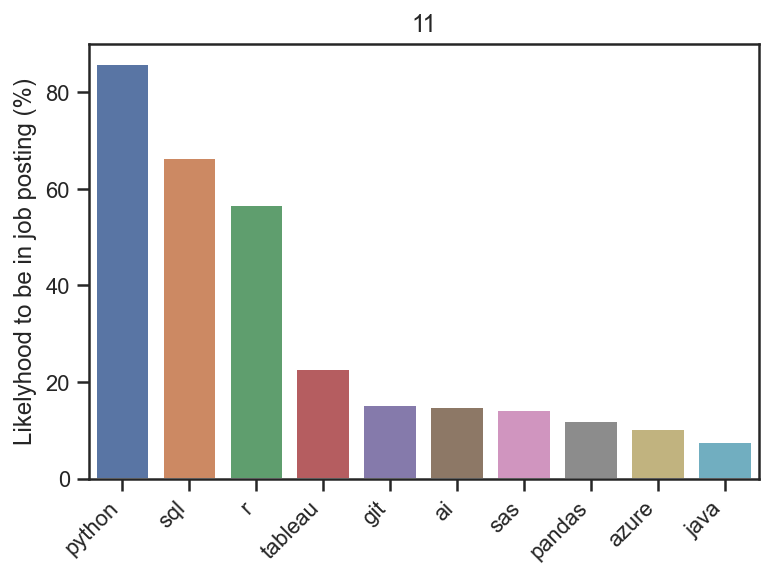

    keywords  counts  percentage
8     python     260   85.808581
21       sql     201   66.336634
42         r     172   56.765677
278  tableau      69   22.772277
464      git      46   15.181518
474       ai      45   14.851485
502      sas      43   14.191419
596   pandas      36   11.881188
691    azure      31   10.231023
920     java      23    7.590759


In [122]:
filtered_keywords(scientist_entry, keywords_analyst, 11)

### Data Engineer Analysis

In [123]:
engineer_entry = filtered_df(jobs_all, "Engineer", "Entry level")

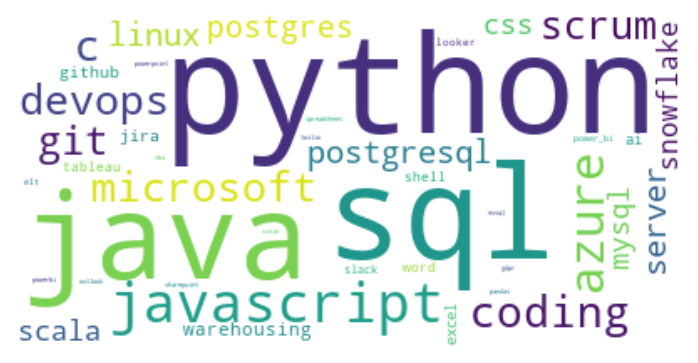

In [124]:
word_cloud(engineer_entry, keywords_analyst)

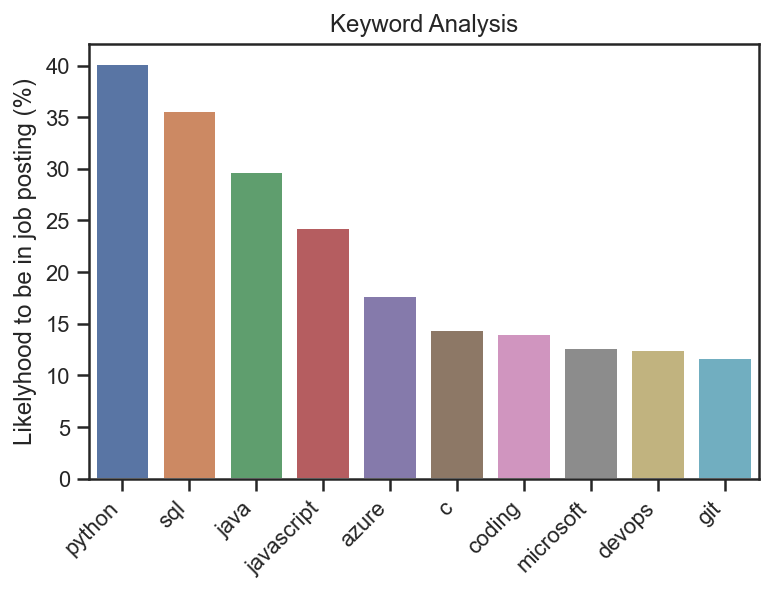

       keywords  counts  percentage
86       python    1106   40.101523
108         sql     983   35.641769
153        java     819   29.695431
218  javascript     668   24.220450
326       azure     488   17.693981
427           c     397   14.394489
440      coding     385   13.959391
488   microsoft     349   12.654097
499      devops     343   12.436548
530         git     321   11.638869


In [125]:
filtered_keywords(engineer_entry, keywords_analyst)